In [ ]:
#esto sirve para borrar carpetas
#import shutil
#shutil.rmtree('/content/README.md')

In [ ]:
# esto es para permitir tener acceso a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# esto es para la ruta del archivo zip, una vez conectado con drive se puede buscar el archivo
# en el explorador de colab darle click derecho y pegar el path
zip_path = '/content/drive/MyDrive/numbers.zip'

# no pongo /content/numbers porque al descomprimir ya crea una carpeta que se llama numbers
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



In [ ]:
import zipfile

# esto es para la data original
zip_path2 = '/content/drive/MyDrive/img.zip'
extract_path = '/content/img'

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import ops

In [ ]:
def count_files_in_polymnist(source_base_path):
    count_by_m_folder = defaultdict(int)
    count_by_class = defaultdict(int)

    for split in ['train', 'test']:
        split_path = os.path.join(source_base_path, split)
        print(f"\n=== {split.upper()} ===")

        for m_folder in ['m0', 'm1', 'm2', 'm3', 'm4']:
            m_path = os.path.join(split_path, m_folder)
            if not os.path.exists(m_path):
              print(f"folder {m_path} not found")
              continue

            files = [f for f in os.listdir(m_path) if f.endswith('.png')]
            count_by_m_folder[m_folder] = len(files)
            print(f"{m_folder}: {len(files)} archivos")

            for filename in files:
                label = filename.split('.')[-2]
                count_by_class[label] += 1

    return count_by_class

def count_files_in_new_folder(source_base_path):
    count_by_m_folder = defaultdict(int)
    count_by_class = defaultdict(int)

    distribution = {"train":{}, "test":{}}


    for split in ['train', 'test']:
        split_path = os.path.join(source_base_path, split)
        print(f"\n=== {split.upper()} ===")

        for m_folder in range(10):
            m_path = os.path.join(split_path, str(m_folder))
            if not os.path.exists(m_path):
                continue

            files = [f for f in os.listdir(m_path) if f.endswith('.png')]
            count_by_m_folder[m_folder] = len(files)
            print(f"{m_folder}: {len(files)} archivos")
            distribution[split][m_folder] = len(files)

            for filename in files:
                label = filename.split('.')[-2]
                count_by_class[label] += 1

    #print("\n=== RESUMEN POR CLASE ===")
    #for label in sorted(count_by_class.keys()):
    #    print(f"Clase {label}: {count_by_class[label]} imágenes")

    return count_by_class, distribution



In [ ]:
# Rutas
source_base_path = '/content/img/PolyMNIST/MMNIST'

# Contar archivos antes de reorganizar
print("=== CONTEO INICIAL ===")
original_count = count_files_in_polymnist(source_base_path)
print(original_count)

=== CONTEO INICIAL ===

=== TRAIN ===
m0: 60000 archivos
m1: 60000 archivos
m2: 60000 archivos
m3: 60000 archivos
m4: 60000 archivos

=== TEST ===
m0: 10000 archivos
m1: 10000 archivos
m2: 10000 archivos
m3: 10000 archivos
m4: 10000 archivos
defaultdict(<class 'int'>, {'9': 34790, '5': 31565, '2': 34950, '7': 36465, '6': 34380, '4': 34120, '0': 34515, '3': 35705, '1': 39385, '8': 34125})


# Analisis de datos originales

Al descargar directamente el set de datos de numeros, este no está directamente en un formato apropiado para procesarlo con una red neuronal. Como se puede ver en el output, si se tiene una carpeta de test y otra de train pero el contenido de las carpetas no es directamente los numeros separados. Se tienen carpetas numeradas del 0 al 4 con la letra m. Por lo que hemos visto, cada m_n carpeta es un "tipo de numero", por ejemplo todos los números de la carpeta m1 parecen ser imagenes con colores y tipo de escritura similar, sin embargo dentro de las carpetas "m" no estan clasificados los numeros. Es decir hay miles de numeros de distintos numeros en todas las carpetas.

![original data](other/original_files.png)

El formato de las imágenes dentro de las carpetas es grupo_numeroReal.png, osea 0.4.png en la carpeta m1, representa una imagen del grupo 1 de la carpeta m1 que es un número 4. En total todas las carpetas "m" en train tienen 60,000 archivos. En el caso del test cada subcarpeta tiene 10,000 archivos. Vemos que los datos están balanceados pero, la idea de este proyecto es poder reconocer/clasificar imagenes mediante una red neuronal, por lo que es necesario re ordenar los datos de forma que train tiene 10 subcarpetas (nummeradas del 0 al 9) donde cada una de estas representen un numero del 0 al 9. Esto lo realizamos mediante un script, esto hará que el procesamiento sea más sencillo usando keras. Otro dato importante, las imagenes sonde 28x28, por lo que no es necesario tanto pre procesamiento para el tamaño.

# Script usado para organizar los datos


Lo que hacemos es iterar en las carpetas y archivos para clasificar los números copiando las imagenes. Podemos identificar de manera sencilla cual es el valor real de la imagen usando el numero que está despues del punto.

In [ ]:
import os
import shutil
from collections import defaultdict

def reorganize_polymnist(source_base_path, target_base_path):
    for split in ['train', 'test']:
        for class_num in range(10):
            os.makedirs(os.path.join(target_base_path, split, str(class_num)), exist_ok=True)

    for split in ['train', 'test']:
        split_source_path = os.path.join(source_base_path, split)
        split_target_path = os.path.join(target_base_path, split)

        for m_folder in ['m0', 'm1', 'm2', 'm3', 'm4']:
            m_path = os.path.join(split_source_path, m_folder)
            if not os.path.exists(m_path):
                print("No path with: ", m_path)
                continue

            for filename in os.listdir(m_path):
                if filename.endswith('.png'):
                    label = filename.split('.')[-2]
                    new_filename = f"{m_folder}_{filename}"
                    target_folder = os.path.join(split_target_path, label)
                    src_path = os.path.join(m_path, filename)
                    dst_path = os.path.join(target_folder, new_filename)
                    shutil.copy(src_path, dst_path)

# Resultado de organizar la data
Estructura nueva      |  Ejemplo de carpeta
:-------------------------:|:-------------------------:
![estructura](other/num_folders.png)  |  ![ejemplo](other/ej_folder.png)

Ahora con esta distribución de datos podemos verificar realmente el balance de los datos, por clase (cantidad de imagenes por número)

In [ ]:
# Rutas
base_path = '/content/numbers'

# Ejecutar la función
count_by_class, distribution = count_files_in_new_folder(base_path)

print(distribution)



=== TRAIN ===
0: 29615 archivos
1: 33710 archivos
2: 29790 archivos
3: 30655 archivos
4: 29210 archivos
5: 27105 archivos
6: 29590 archivos
7: 31325 archivos
8: 29255 archivos
9: 29745 archivos

=== TEST ===
0: 4900 archivos
1: 5675 archivos
2: 5160 archivos
3: 5050 archivos
4: 4910 archivos
5: 4460 archivos
6: 4790 archivos
7: 5140 archivos
8: 4870 archivos
9: 5045 archivos
{'train': {0: 29615, 1: 33710, 2: 29790, 3: 30655, 4: 29210, 5: 27105, 6: 29590, 7: 31325, 8: 29255, 9: 29745}, 'test': {0: 4900, 1: 5675, 2: 5160, 3: 5050, 4: 4910, 5: 4460, 6: 4790, 7: 5140, 8: 4870, 9: 5045}}


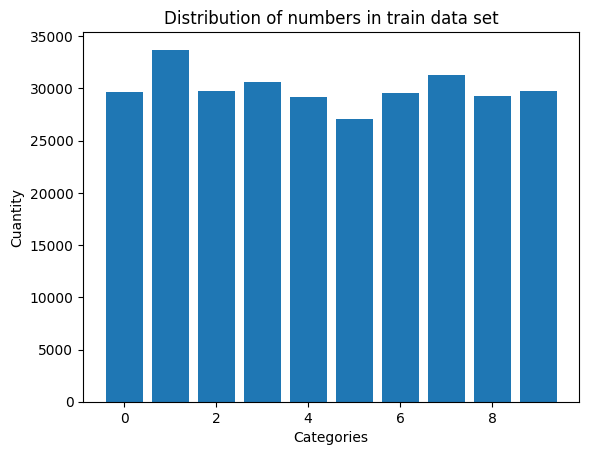

In [ ]:
train_x_values = list(distribution["train"].keys())
train_y_values_count = list(distribution["train"].values())

plt.bar(train_x_values, train_y_values_count)
plt.xlabel('Categories')
plt.ylabel('Cuantity')
plt.title('Distribution of numbers in train data set')
plt.show()

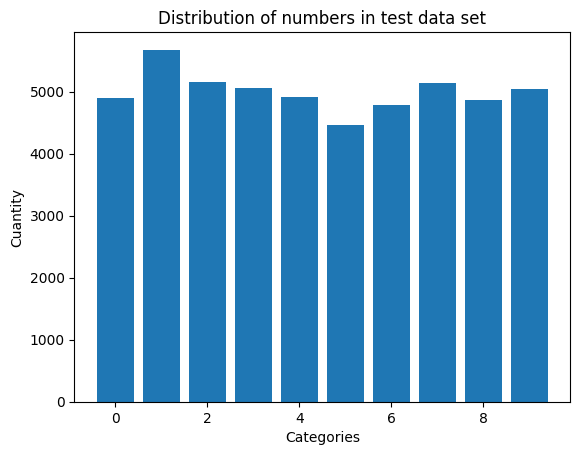

In [ ]:
test_x_values = list(distribution["test"].keys())
test_y_values_count = list(distribution["test"].values())

plt.bar(test_x_values, test_y_values_count)
plt.xlabel('Categories')
plt.ylabel('Cuantity')
plt.title('Distribution of numbers in test data set')
plt.show()

Como se puede ver la clase que tiene más valores es la del número 1 y la que tiene menos es el 5. Tanto los números en el test y train parecen tener la misma distribución de datos. Ahora bien, podríamos hacer un downsampling para que los datos estén completamente balanceados con la clase de menor cantidad, pero viendo las gráficas nos parece que realmente la data esta bastante bien balanceada. Y ya que realmente tenemos una gran cantidad de datos de todos los números no es necesario hacer cambios con respecto al balance o la cantidad de valores en testing y training. Con esto tenemos los datos listos para realizarlo los modelos.

In [5]:
# Rutas
base_path = '/content/numbers'

# Ejecutar la función
count_by_class, distribution = count_files_in_new_folder(base_path)

print(distribution)



=== TRAIN ===
0: 29615 archivos
1: 33710 archivos
2: 29790 archivos
3: 30655 archivos
4: 29210 archivos
5: 27105 archivos
6: 29590 archivos
7: 31325 archivos
8: 29255 archivos
9: 29745 archivos

=== TEST ===
0: 4900 archivos
1: 5675 archivos
2: 5160 archivos
3: 5050 archivos
4: 4910 archivos
5: 4460 archivos
6: 4790 archivos
7: 5140 archivos
8: 4870 archivos
9: 5045 archivos
{'train': {0: 29615, 1: 33710, 2: 29790, 3: 30655, 4: 29210, 5: 27105, 6: 29590, 7: 31325, 8: 29255, 9: 29745}, 'test': {0: 4900, 1: 5675, 2: 5160, 3: 5050, 4: 4910, 5: 4460, 6: 4790, 7: 5140, 8: 4870, 9: 5045}}


Luego de ver que tenemos todos los datos cargados de la carpeta numbers, se puede prosegir con el entrenamiento de los modelos. Primer se realizaran 2 modelos de redes convolucionales. Utilizando tensorflow y keras, creamos los modelos usando específicamente ImageDataGenerator. Podemos hacer esto ya que le dimos la estructura apropiada a las carpetas, teniendo separado test y train y cada uno con una carpeta por cada clase (los números de lo 0 al 9). Para la configuración desribimos la ruta de la carpeta train y la de test. Usamos una tamaño de batch de 32, colocamos que las imagenes son a color, que queremos clasificar por categoría y también la resolución de las imagenes, 28x28 pixeles.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/numbers/train'
test_dir = '/content/numbers/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

Found 300000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


Podemos ver que en efecto se han detecctado las imagenes y también las clases correctamente.

# Modelo 1 CNN

Este modelo CNN está diseñado para clasificar imágenes de dígitos del 0 al 9 como ya se menionó antes y sigue una arquitectura profunda con tres bloques convolucionales. Comienza con una capa Conv2D de 32 filtros (3x3) y activación ReLU. Luego tiene BatchNormalization para acelerar el entrenamiento. También MaxPooling2D (2x2) para reducir dimensiones y Dropout (25%) para evitar overfitting. El segundo bloque repite esta estructura pero con 64 filtros, mientras que el tercero usa 128 filtros sin pooling. Tras aplanar los datos usando flatten, se añaden dos capas densas, una con 256 neuronas ReLU, BatchNormalization y Dropout (50%), y una final con 10 neuronas y activación softmax para la clasificación multiclase. 

El modelo se compila con el optimizador Adam con una tasa de aprendizaje de 0.001. Elegimos no dar pasos mu largos con el learning rate para capturar bien las relaciones en la red. Se mide la pérdida categorical_crossentropy y métrica de precisión (accuracy). La idea con esta y las demás arquitecturas será balancear entre desempeño del modelo y tiempo de procesamiento, ya que hay que tener en mente que tenemos una cantidad enorme de datos. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Definir modelo CNN
model_cnn = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloque 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloque 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    # Capas finales
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Resumen del modelo
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,906 (1.50 MB)

 Trainable params: 391,946 (1.50 MB)

 Non-trainable params: 960 (3.75 KB)

# Entrenamiento del modelo CNN

Para el entrenamiento es imporante tener en cuenta también el batch size y las epocas. Debido al tamaño del set de datos elegimos 15 épocas con un batch size de 64 como punto de inicio. Además de tener presente el early stopping en caso el modelo deje de aprender significativamente con el paso de las epocas o incluso por si este llega a emperoar.

In [9]:
# Configuración de entrenamiento
epochs = 15
batch_size = 64
# Calcular steps por epoch (para datasets grandes)
train_steps = train_generator.samples // batch_size
val_steps = test_generator.samples // batch_size

# Callback para early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=val_steps,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 159s 34ms/step - accuracy: 0.9649 - loss: 0.1132 - val_accuracy: 0.9816 - val_loss: 0.0551
Epoch 2/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 203s 43ms/step - accuracy: 0.9672 - loss: 0.1033 - val_accuracy: 0.9819 - val_loss: 0.0559
Epoch 3/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9688 - loss: 0.0796 - val_accuracy: 0.9822 - val_loss: 0.0550
Epoch 4/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 160s 34ms/step - accuracy: 0.9687 - loss: 0.0969 - val_accuracy: 0.9829 - val_loss: 0.0535
Epoch 5/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 159s 34ms/step - accuracy: 0.9711 - loss: 0.0910 - val_accuracy: 0.9804 - val_loss: 0.0589
Epoch 6/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9688 - loss: 0.0909 - val_accuracy: 0.9811 - val_loss: 0.0572
Epoch 7/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 212s 34ms/step - accuracy: 0.9730 - loss: 0.0844 - val_accuracy: 0.9865 - val_loss: 0.0431
Epoch 8/15
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 162s 34ms/step - accuracy: 0.97

781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9872 - loss: 0.0397

Precisión final en test: 98.64%


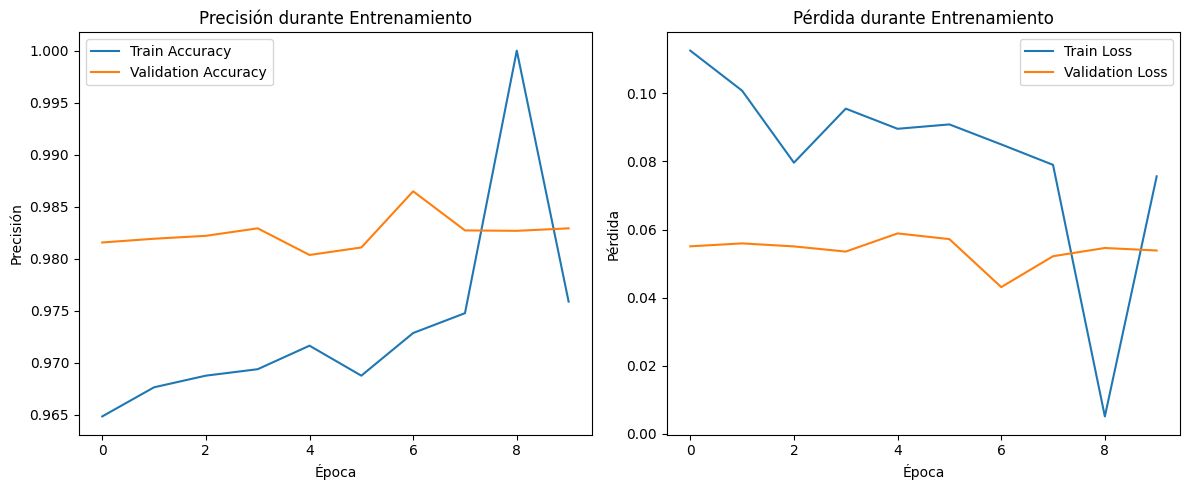

In [10]:
import matplotlib.pyplot as plt

# Evaluación final
loss, acc = model_cnn.evaluate(test_generator, steps=val_steps, verbose=1)
print(f'\nPrecisión final en test: {acc*100:.2f}%')

# Gráficas de entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión durante Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

Viendo la grafica resultante para el desempeño del modelo y la función de perdida, es claro que han habido algunos problemas en el entrenamiento del modelo. Primero, observando la gráfica del accuracy, se puede ver que desde un principio el modelo empieza con un accuracy bastante alto desde la época 1. A medida que avanzan las épocas el modelo en vez de mejorar empeor, esto se ve en la época 4 -> 5 pero es aún más raro el comportamiento de la época 7 a la  9. En este caso el accuracy llega a ser de 1 y luego baja a 97 en la época 9, activando el early stopping y deteniendo el entrenamiento.

En el caso del entrenamiento la situación es similar pero a la inversa, durante algunas épocas en lugar de reducirse el error este aumenta y en la epoca 8 se ve reflejado el alto accuracy, habiendo un error de 0 que luego aumenta. Este comportamiento es inusual y refleja overfitting. Otro comporatmiento extraño fue directamente en los tiempos de entrenamiento, donde las epocas 2,6 y 9 tardaron tan solo 10 segundos. El modelo parece haber sufrido de overfitting y se termino el entrenamiento antes por el early stoppping. Sabiendo esto hay que hacer ajustes para el segundo modelo. Aunque es cierto que sobre el set de datos de test el accuracy fue de 98, es , mejor realziar ajustes para el que modelo generalice mejor la data. 

In [11]:
# Guardar modelo en formato .keras (recomendado)
model_cnn.save('/content/drive/My Drive/modelo_cnn_digitos.keras')

# Opcional: Guardar también en HDF5 para compatibilidad
model_cnn.save('/content/drive/My Drive/modelo_cnn_digitos.h5')

# Modelo 2 CNN con algunos ajustes

Este segundo modelo es una versión optimizada para contrarrestar el overfitting en la clasificación de dígitos (0-9), manteniendo la estructura base pero con ajustes en la regularización. Se incrementó el Dropout en los bloques convolucionales de 0.25 a 0.3 en los dos primeros bloques y 0.4 en el tercero. También se simplificó la arquitectura: el tercer bloque ya no incluye MaxPooling, y la capa densa final se redujo de 256 a 128 neuronas, conservando un Dropout del 50%. La idea de ir aumentando el dropout es para reducir overfitting en el entrenamiento, ya que esto apaga neuronas aleatoriamente durante el entrenamiento.

La compilación se mantuvo igual con Adam con lr=0.001 y categorical_crossentropy, pero el modelo ahora es más ligero y con mayor énfasis en la regularización, para manejar eficientemente los 300k datos de entrenamiento sin sacrificar generalización en el conjunto de 50k pruebas.

In [19]:
model_cnn_v2 = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),  # Aumentado de 0.25

    # Bloque 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),  # Aumentado

    # Bloque 3 (simplificado)
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Aumentado

    # menos Capas finales
    Flatten(),
    Dense(128, activation='relu'),  # Reducido de 256
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model_cnn_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
model_cnn_v2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,018 (949.29 KB)

 Trainable params: 242,570 (947.54 KB)

 Non-trainable params: 448 (1.75 KB)

Para mejorar el entrenamiento del modelo, se mantuvo el EarlyStopping y ahora se tiene también ReduceLROnPlateau. El primero monitorea la pérdida en validación y detiene el entrenamiento si no mejora en al menos 0.001 durante 5 épocas (definidas por el patience), restaurando los mejores pesos obtenidos, lo que evita sobreentrenamiento y ahorra tiempo. El segundo reduce el learning rate en un 20% (factor=0.2) si val_loss no mejora en 2 épocas, hasta un mínimo de 1e-6 (min_lr), con esta configuración dinámica para el a´prendizaje se propuso mejorar el modelo.



In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

callbacks = [early_stop, reduce_lr]

Y finalmente con el entrenamiento hay 2 cambios clave. El primero es la cantidad de épocas, previamente se vió claramente que debido a la naturaleza del algoritmo y los datos, no es necesario realizar tantas épocas. Llegando a parar en 9 épocas por el eraly stopping antes. Entonces proponemos usar 8 épocas, pero y aque hacemos más dropout y hay menos neuronas, usaremos n batch size más pequeño, específicamente de 32 con la idea de analizar procesar bastante información sin caer en sobreajuste.

In [21]:
# Configuración de entrenamiento
epochs = 8
batch_size = 32

# Calcular steps
train_steps = train_generator.samples // batch_size
val_steps = test_generator.samples // batch_size

# Entrenamiento
history_v2 = model_cnn_v2.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/8
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 318s 34ms/step - accuracy: 0.8090 - loss: 0.6190 - val_accuracy: 0.9401 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 2/8
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 314s 33ms/step - accuracy: 0.9450 - loss: 0.1811 - val_accuracy: 0.9763 - val_loss: 0.0721 - learning_rate: 0.0010
Epoch 3/8
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 312s 33ms/step - accuracy: 0.9561 - loss: 0.1453 - val_accuracy: 0.9807 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 4/8
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 323s 33ms/step - accuracy: 0.9614 - loss: 0.1258 - val_accuracy: 0.9820 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 5/8
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 312s 33ms/step - accuracy: 0.9655 - loss: 0.1132 - val_accuracy: 0.9798 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 6/8
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 314s 34ms/step - accuracy: 0.9682 - loss: 0.1043 - val_accuracy: 0.9859 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 7/8
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 314s 33ms/step - accura

Solo con el historial de entrenamiento ya e puede ver una mejora. Antes las epocas 3,6 y 9 duraban mucho menos que todas las demás. En este caso podemos ver que el tiempo de todas las épocas fue aproxiamdamente el mismo y no hubieron casos en los que el modelo empeorara en un época en lugar de mejorar. Se logró un accuracy de 97, algo bastante bueno y que inspira mas confianza viendo el entrenamiento y que no quedó con un accuracy de 100.

In [22]:
# Evaluación con el conjunto de test
test_loss, test_acc = model_cnn_v2.evaluate(test_generator, steps=val_steps)
print(f'\nPrecisión final en test: {test_acc*100:.2f}%')
print(f'Pérdida final en test: {test_loss:.4f}')

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9867 - loss: 0.0440

Precisión final en test: 98.59%
Pérdida final en test: 0.0463


La prueba con el set de test da muy buenos resultados, con un accuracy de 98.69% y una pérdida de 0.0463. El modelo resultó ser muy eficientne y logra clasificar bastante bien. Esto lo podemos corroborar con el comportamiento de las siguientes gráficas.

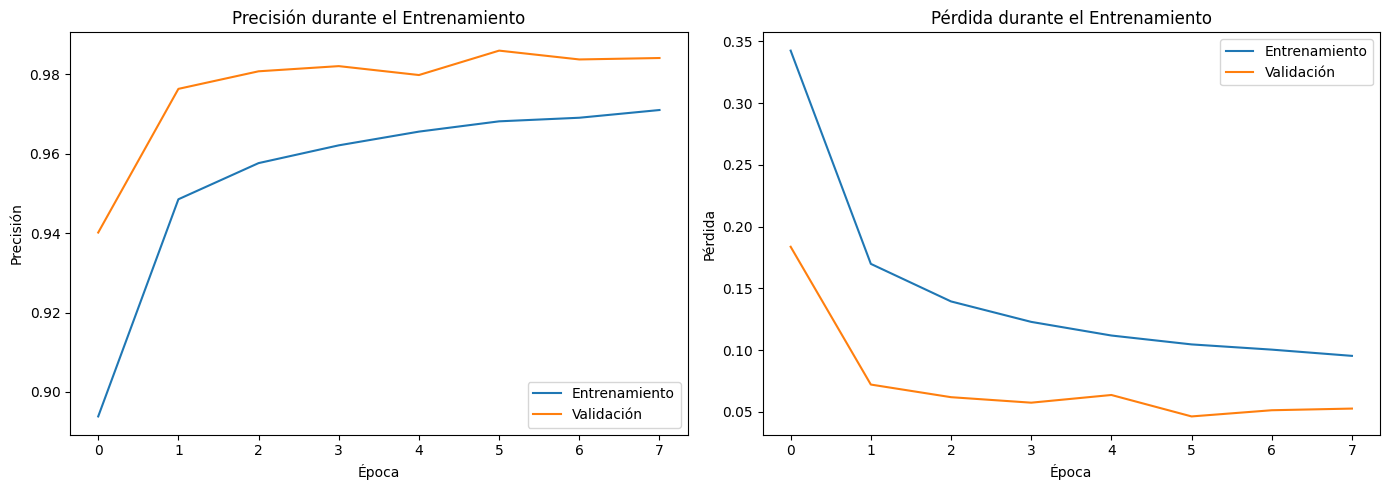

In [23]:
import matplotlib.pyplot as plt

# Gráficas de entrenamiento
plt.figure(figsize=(14, 5))

# Gráfica de precisión
plt.subplot(1, 2, 1)
plt.plot(history_v2.history['accuracy'], label='Entrenamiento')
plt.plot(history_v2.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)
plt.plot(history_v2.history['loss'], label='Entrenamiento')
plt.plot(history_v2.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

En este caso el comportamiento del accuracy y la pérdida es mejor. Las gráficas tienen un comportamiento normal y se puede ver que el modelo aprendió relativamente rápido. Luego de la primera época con se obtuvo un accuracy mayor a 90 y fue aumetando ligeramente con cada época. En ningún momento empeoró y al final de la última época se puede ver que el entrenamiento va a converger con la validación, en la gráfica de pérdida. El modelo bien podría tener más épocas para aumentar poco a poco el accuracy, pero arriesgariamos poder llegar a sobreajuste. El accuray de por si ya es bastante alto y seguramente de aumentar las épocas la mejora sería muy lenta o poco significativa.

Con esto logramos hacer un modelo que generaliza mucho mejor que el primero junto con bastante accuracy en el set de entrenamiento. Ahora podemos probar otros tipos de redes y comprar el rendimiento.

# Modelo de red neuronal simple

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/numbers/train'
test_dir = '/content/numbers/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

Found 300000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


Esta red neuronal simple de igual manera es para procesar imágenes RGB de dígitos de 28x28 píxeles. La arquitectura comienza con una capa Flatten que transforma cada imagen en un vector unidimensional de 2,352 características (28×28×3), manteniendo toda la información de la imagen. Usamos tres capas densas con activación ReLU (512, 256 y 128 neuronas respectivamente), donde cada capa reduce progresivamente su dimensionalidad para extraer características. Entre estas capas ocultas, hemos incluido Dropout con tasa de 0.2 para prevenir sobreajuste, eliminando aleatoriamente el 20% de las conexiones durante el entrenamiento. COn esto hacemos que la red aprenda y generalice mejor. 

La capa final usa activación softmax para clasificación multiclase, generando probabilidades para los 10 dígitos posibles. El optimizador Adam con learning rate de 0.001 es útil para definir la rapidez de convergencia y además seguimos usando categorical_crossentropy ya que es bueno para problemas de clasificación con múltiples clases excluyentes. Nuestra métrica también seguirá siendo el accuracy.

El tamaño decreciente de las capas (512→256→128) actúa como funnel que va refinando las características aprendidas, y la ausencia de capas convolucionales hace que el modelo sea un poco más ligero.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir el modelo
model = Sequential([
    Flatten(input_shape=(28, 28, 3)),  # Aplanar la imagen (28x28x3 para RGB)
    Dense(512, activation='relu'),     # Capa oculta con 512 neuronas
    Dropout(0.2),                      # Regularización para evitar overfitting
    Dense(256, activation='relu'),     # Otra capa oculta
    Dropout(0.2),
    Dense(128, activation='relu'),     # Capa oculta adicional
    Dense(10, activation='softmax')    # Capa de salida (10 clases)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,204,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,250 (5.23 MB)

 Trainable params: 1,370,250 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo con una rede neuronal simple

Esta implementación utiliza 15 épocas, un número equilibrado que permite que el modelo aprenda lo suficiente sin caer en sobreajuste, considerando que el conjunto de entrenamiento es de 300k imágenes, muchas épocas tardaría demasiado y seguramente luego de cierta cantidad de épocas deje de mejorar. El batch_size de 32 es un valor estándar, procesando 32 muestras antes de ajustar los parámetros del modelo. Los steps por época se calculan automáticamente dividiendo el total de imágenes entre el batch_size, asegurando que en cada época se recorra todo el dataset sin repeticiones o muestras ignoradas.

El entrenamiento se ejecuta con el generador de datos (train_generator), que carga las imágenes en lotes y aplica normalización (rescale=1./255). Además, se valida en tiempo real con el test_generator, lo que permite monitorear el rendimiento en datos no vistos y detectar sobreajuste temprano. El parámetro verbose=1 muestra el progreso por época incluyendo las métricas.

In [ ]:
# Configuración del entrenamiento
epochs = 15
batch_size = 32

# Calcular steps por epoch
train_steps = train_generator.samples // batch_size
val_steps = test_generator.samples // batch_size

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=val_steps,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 564s 60ms/step - accuracy: 0.4816 - loss: 1.4835 - val_accuracy: 0.7451 - val_loss: 0.7985
Epoch 2/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 376s 34ms/step - accuracy: 0.6903 - loss: 0.9388 - val_accuracy: 0.7787 - val_loss: 0.6967
Epoch 3/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 321s 34ms/step - accuracy: 0.7260 - loss: 0.8385 - val_accuracy: 0.8025 - val_loss: 0.6228
Epoch 4/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 312s 33ms/step - accuracy: 0.7452 - loss: 0.7798 - val_accuracy: 0.8112 - val_loss: 0.6027
Epoch 5/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 329s 34ms/step - accuracy: 0.7571 - loss: 0.7465 - val_accuracy: 0.8232 - val_loss: 0.5667
Epoch 6/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 341s 36ms/step - accuracy: 0.7663 - loss: 0.7203 - val_accuracy: 0.8108 - val_loss: 0.5885
Epoch 7/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 367s 35ms/step - accuracy: 0.7718 - loss: 0.7036 - val_accuracy: 0.8264 - val_loss: 0.5597
Epoch 8/15
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 446s 42ms/step - accuracy: 

Luego del entrenamiento se puede ver que el comportamiento de las epocas es relativamente similar. No hay épocas donde el modelo haya empeorado o que haya tardado significativamente menos que los demás. Llegando a un accuracy durante el entrenamiento de 80, el modelo es bastatne bueno para predecir y no parece haber overfitting a simple vista. Aunque esto se confirmará con las gráficas siguientes.

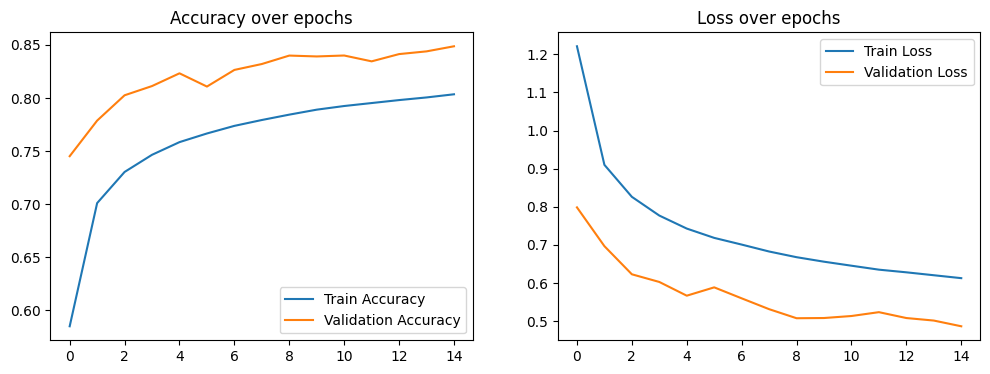

In [ ]:
import matplotlib.pyplot as plt

# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8495 - loss: 0.4866
> 84.874


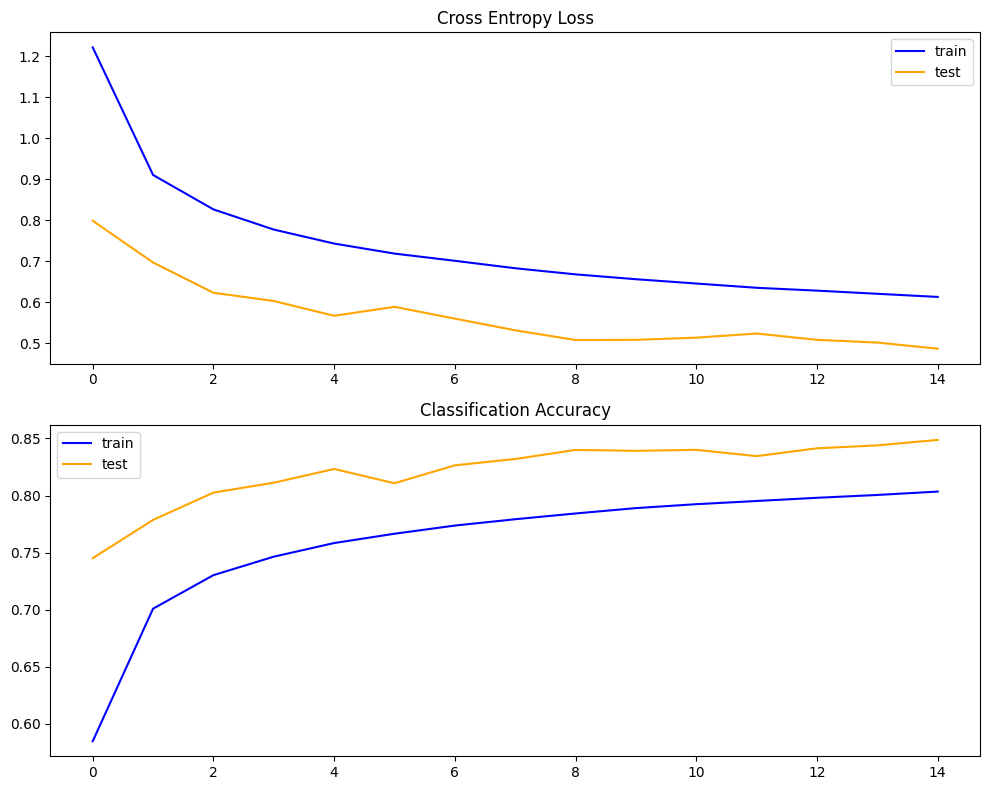

In [ ]:
# Evaluación final
loss, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('> %.3f' % (acc * 100.0))

# Gráficas
plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()

plt.tight_layout()
plt.show()

En las gráficas es puede ver que el módelo parece aprender a un buen rítmo. La curva de perdida parece converger cada vez más, aunque ha medida que aumentaron las épocas, la reducción de la perdida cada vez fue menos. De haber aumentado las épocas la gráfica no hubiera mejorado. Inicialmente entre las primeras 3 épocas es que se tiene la mayor mejora, y esto se puede apreciar tanto en el gráfico de loss como en el de accuracy. A partir de la 4 época los cambios cada vez fueron menores hasta que el modelo pareciera quedarse con un accuracy de alredador del 80%. 

El comportamiento de las gráficas es bastante bueno y la forma de convergencia no muestra overfitting. Por lo que la configuración fue buena para manejar el sobreajuste y el entrenamiento. Comparado con los modelos previos es singificativamene de menor calidad, si comparamos con el accuracy. Por lo que podemos decir con confianza que realmente una red convolucional, debido a las capas y la forma en la que se procesan las imagenes, es un algoritmo más apto para el reconocimiento de imagenes.  



In [ ]:
model.save('mi_modelo_digitos.h5')

# Para el formato .h5
#files.download('mi_modelo_digitos.h5')

model.save('/content/drive/My Drive/mi_modelo.h5')
model.save('/content/drive/My Drive/mi_modelo_digitos.keras')